In [1]:
from commonconstants import *
import pandas as pd
import numpy as np
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
import itertools
%matplotlib notebook 

In [2]:
np.set_printoptions(suppress=True)

In [3]:
def read_dataset(filename):
    return pd.read_pickle(filename)

In [4]:
dataset = read_dataset('./data/validation_label.pickle')
dataset = pd.DataFrame(dataset, dtype='int32')

In [5]:
# Number of distinct label
number_of_labels = dataset['labelId'].nunique()
maximum_label_id = max(dataset['labelId'])
print('Number of distinct labels in the dataset : ', number_of_labels)
print('Maximum id if labels in the dataset : ', maximum_label_id)
# Number of distinct images
number_of_images = dataset['imageId'].nunique()
print('Number of distinct images in the dataset : ', number_of_images)

Number of distinct labels in the dataset :  225
Maximum id if labels in the dataset :  228
Number of distinct images in the dataset :  9897


In [6]:
# Count analysis for images
count_by_image_id = dataset.groupby('imageId')['imageId'].count().reset_index(name="count")

In [7]:
# Plot by label counts
print(' Images with largest number of labels ')
count_by_image_id.nlargest(5, 'count')

 Images with largest number of labels 


,imageId,count
4354,4355,19
7176,7177,19
7119,7120,18
9737,9738,18
3202,3203,17


 Number of labels versus number of images with that many labels :


<IPython.core.display.Javascript object>


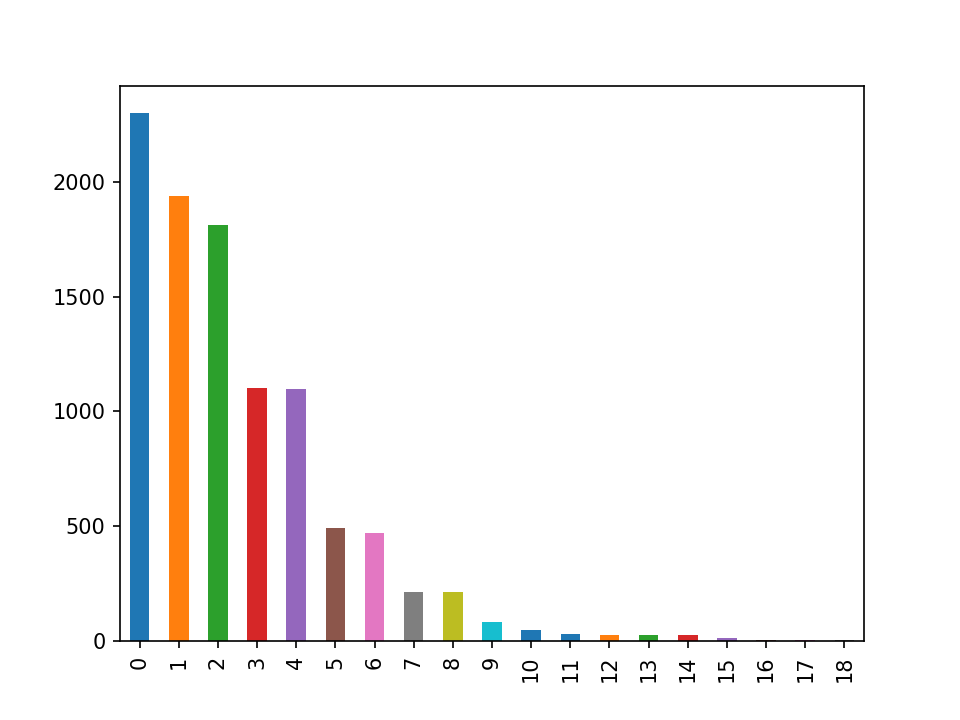

In [8]:
print(' Number of labels versus number of images with that many labels :')
a = count_by_image_id['count'].value_counts().reset_index(name="number_of_images")
a["number_of_images"].plot(kind = 'bar')

In [9]:
count_by_label_id = dataset.groupby('labelId')['labelId'].count().reset_index(name="count")
# Plot by label counts
print('Labels associated with largest number of images ')
count_by_label_id.nlargest(5, 'count')

Labels associated with largest number of images 


,labelId,count
64,66,7606
16,17,4648
218,222,3388
103,105,3375
151,153,2765


<IPython.core.display.Javascript object>


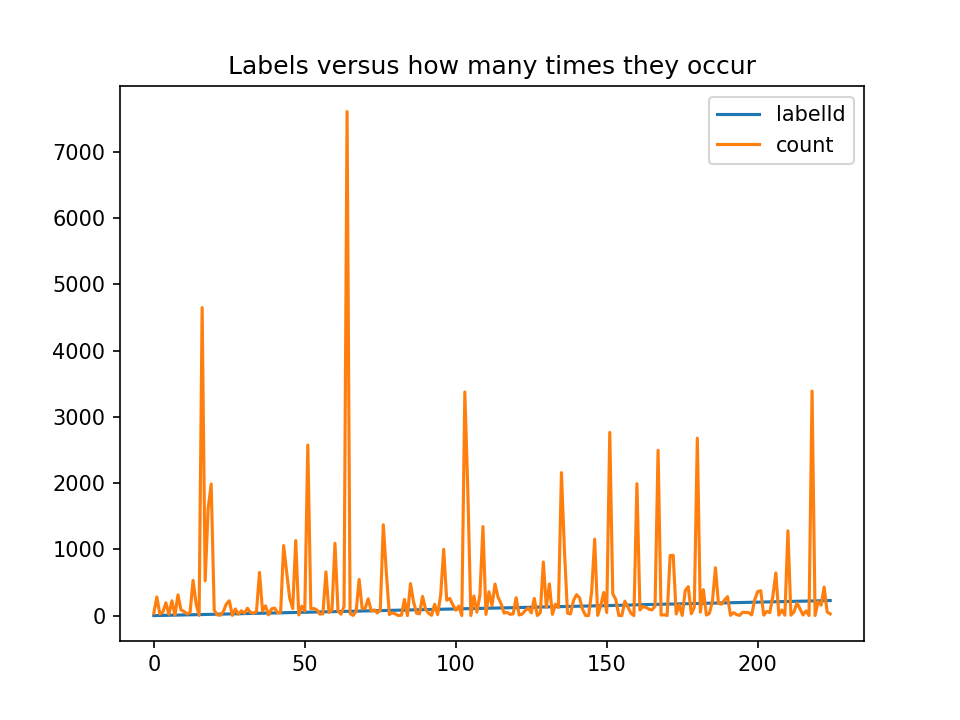

In [10]:
count_by_label_id.plot(title='Labels versus how many times they occur')

Trying to check if some labels occur frequently with other labels. It may tell us that they may be some how related. For example, ties may occur frequently with suits. etc. 

In [22]:
check_relation = np.zeros((maximum_label_id + 1 ,maximum_label_id + 1))
relations = {}
for index, row in dataset.iterrows():
    imageId = row['imageId']
    labelId = row['labelId']
    if imageId in relations:
        for l in relations[imageId]:
            check_relation[l][labelId] += 1
            check_relation[labelId][l] += 1
    else:
        relations[imageId] = []
    relations[imageId].append(labelId)
    
len(relations)

9897

In [23]:
temp = np.copy(check_relation)

In [24]:
#check_relation = np.copy(temp)

In [25]:
closest_companions = np.argsort(temp, axis=1)
closest_companions = (closest_companions[:, -3:])[:,::-1]
print(closest_companions[10])

[ 66 176  17]


In [27]:
companion = pd.DataFrame(columns=['companion'],data = closest_companions[1:,0], index = range(1, closest_companions.shape[0]))
companion['labelId'] = range(1, closest_companions.shape[0])
companion.head()

,companion,labelId
1,66,1
2,66,2
3,106,3
4,17,4
5,105,5


In [28]:
sorted_closest_companions = temp
sorted_closest_companions.sort(axis = 1)
closest_companions_count = (sorted_closest_companions[:, -3:])[:,::-1]
print(closest_companions_count[10])

[87. 53. 47.]


Plot the counts side by side

In [29]:
companion_count = pd.DataFrame(columns=['count'],data = closest_companions_count[1:,0], index = range(1, closest_companions_count.shape[0]))
companion_count['labelId'] = range(1, closest_companions_count.shape[0])
companion_count.head()

,count,labelId
1,25.0,1
2,260.0,2
3,19.0,3
4,34.0,4
5,182.0,5


<IPython.core.display.Javascript object>


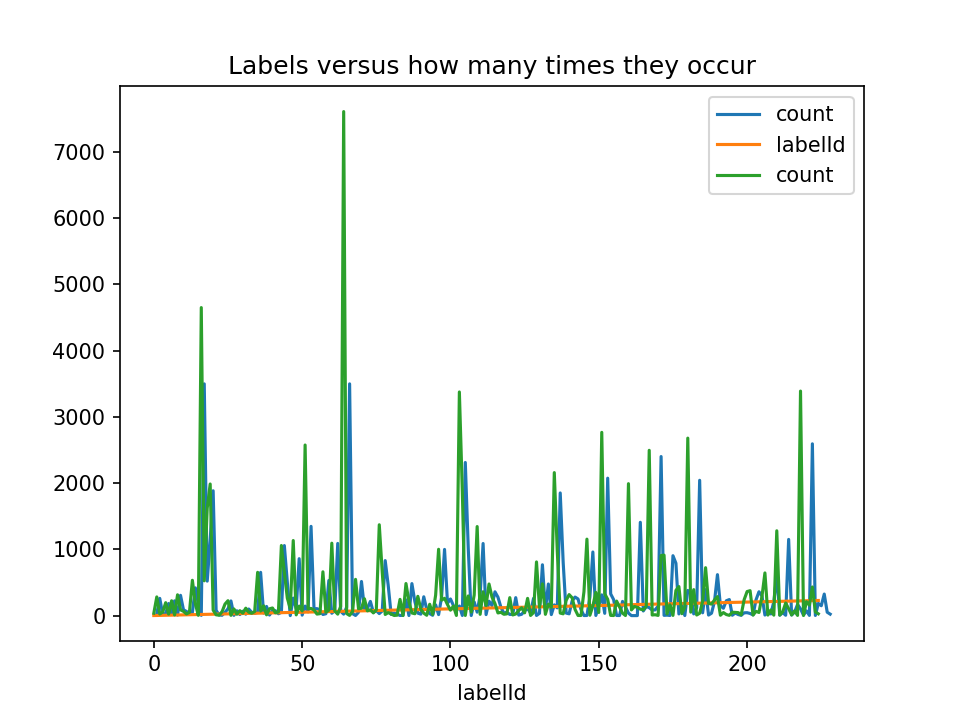

In [31]:
ax = companion_count.plot(title='Labels versus how many times they occur', x='labelId', y='count')
count_by_label_id.plot(ax= ax)

In [33]:
merged = pd.merge(companion_count, count_by_label_id, on='labelId')
merged['percentage'] = (merged['count_x'] / merged['count_y'] ) * 100
merged = pd.merge(merged, companion, on='labelId')
merged

,count_x,labelId,count_y,percentage,companion
0,25.0,1,36,69.444444,66
1,260.0,2,282,92.198582,66
2,19.0,3,24,79.166667,106
3,34.0,4,54,62.962963,17
4,182.0,5,195,93.333333,105
5,18.0,6,22,81.818182,17
6,223.0,7,224,99.553571,66
7,8.0,8,10,80.000000,59
8,306.0,9,314,97.452229,66
9,87.0,10,87,100.000000,66
